In [1]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py

import torch.optim as optim
import time
import json

import torch.nn.functional as F
from torch.nn.modules.utils import _quadruple

In [2]:
class FEM_Solver(nn.Module):
    def __init__(self, dh=5, dt=0.002, c=2500, device='cuda:0'):
        super(FEM_Solver, self).__init__()

        # Parameters of the mesh
        self.dh = dh
        self.dt = dt
        self.c = c
        self.device = device

        self.P = (self.dt ** 2) * (self.c ** 2)/(self.dh ** 2)

        # Kernels filters
        # x FD
        self.weight_h = torch.FloatTensor([[[[ 0,  0,  0],[ 1, -2,  1],[ 0,  0,  0]]]]).to(self.device)
        # y FD
        self.weight_v = torch.FloatTensor([[[[ 0,  1,  0],[ 0, -2,  0],[ 0,  1,  0]]]]).to(self.device) 

        self.padding = _quadruple(1)

    def forward(self,inputs):
        """
        inputs : combination of inputs and outputs of the model, shape = (Minibatch,Channels,Width,Height)
        """    

        # TODO : assert length of channels is 5

        self.u_n = inputs[:,-1:,:,:] 
        self.u_n_1 = inputs[:,-2:-1,:,:]

        # Compute derivatives
        self.u_dxdx = F.conv2d(F.pad(self.u_n, self.padding, mode='circular'), self.weight_h, stride=1, padding=0, bias=None)
        self.u_dydy = F.conv2d(F.pad(self.u_n, self.padding, mode='circular'), self.weight_v, stride=1, padding=0, bias=None)

        # Next time step computed based on the finite difference method for the wave equation : 
        next_u = self.P * self.u_dxdx + self.P * self.u_dydy + 2 * self.u_n - self.u_n_1

        return next_u

class Model(BaseModel):
    def __init__(self, net, opt=None, sched=None, logger=None, print_progress=True, device='cuda:0'):
        super().__init__(net, opt, sched, logger, print_progress, device)

    def forward_loss(self, data):
        return

In [3]:
# Data
data_dir = '../Training_Data/Moseley_Homogeneous/'
data_csv = '../Training_Data/Moseley_Homogeneous_Event0000_Continuous.csv'
event = 'Event0000'

training_data = dataset(data_dir,data_csv,event)

initial_timestep = 20
number_of_timestep_to_predict = 170

In [4]:
model_name = 'LAST_AR_PINN_MSE_E500'
model_type = 'unet'

net = UNet(in_channels=4,out_channels=1)

model = Model(net, device='cuda:0')
model.load(import_path=f'../Training/{model_type}/results/{model_name}.pt',map_location='cuda:0')
model.net = model.net.to(device='cuda:0')

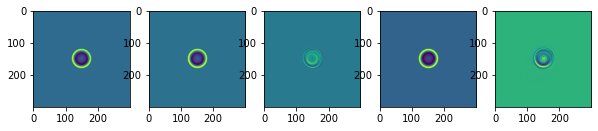

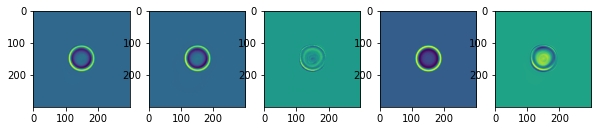

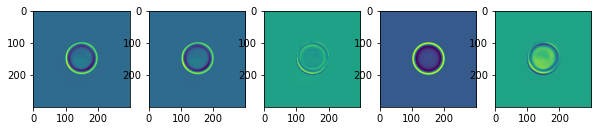

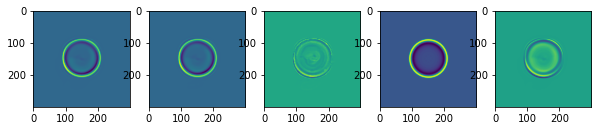

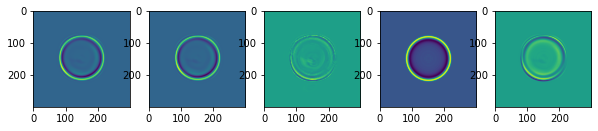

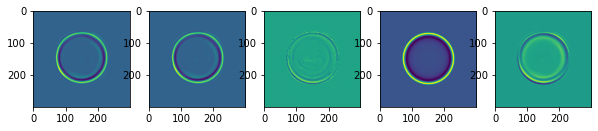

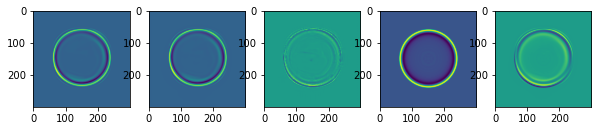

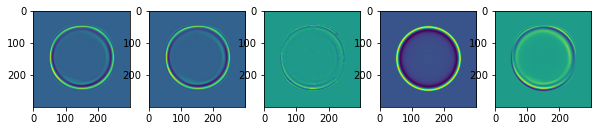

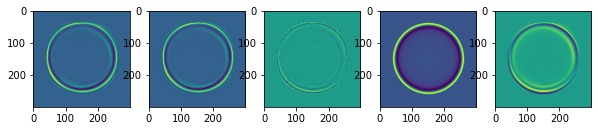

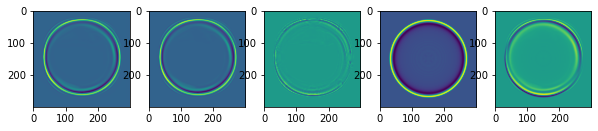

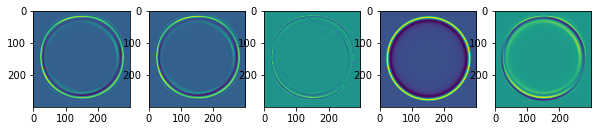

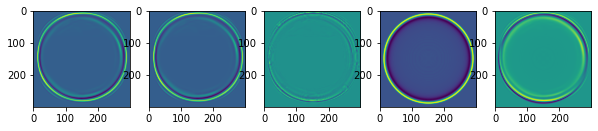

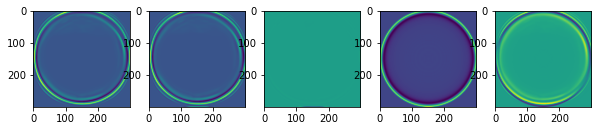

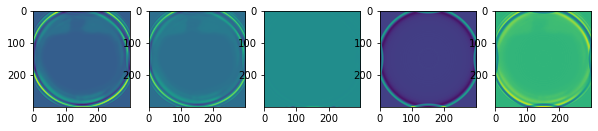

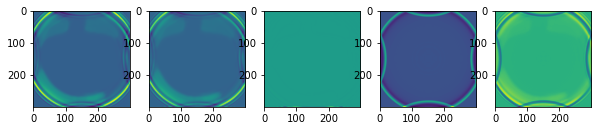

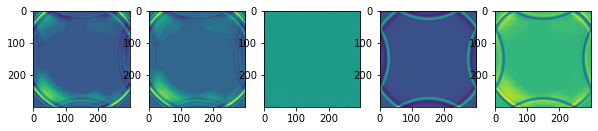

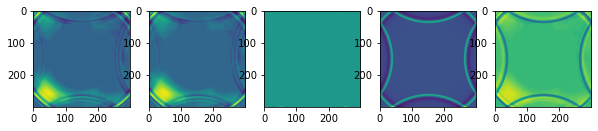

In [5]:
inputs = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]
inputs = inputs.to(device='cuda:0')

fem_solver = FEM_Solver(device='cuda:0')

norms = []
errors_salvus = []
errors_fem = []
errors_fem_salvus = []

for ts in range(number_of_timestep_to_predict):

    # Pred Model
    pred = model.net(inputs).detach()

    # Pred FEM 
    pred_FEM = fem_solver(inputs).detach()

    # True Salvus
    true = training_data.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[0]

    # Update inputs
    inputs = torch.cat((inputs,pred),dim=1)[:,1:,:,:]

    norms.append( np.square( pred.cpu().numpy() - true.cpu().numpy() ).mean() )

    errors_salvus.append( np.mean( np.abs( pred.cpu().numpy() - true.cpu().numpy() ) ) )
    errors_fem.append( np.mean( np.abs( pred.cpu().numpy() - pred_FEM.cpu().numpy() ) ) )
    errors_fem_salvus.append( np.mean( np.abs( true.cpu().numpy() - pred_FEM.cpu().numpy() ) ) )

    if ts % 10 == 1:
        fig, ax = plt.subplots(1,5,figsize=(10,5))
        ax[0].imshow(pred[0,0].cpu().numpy())
        ax[1].imshow(pred_FEM[0,0].cpu().numpy())
        ax[2].imshow(pred[0,0].cpu().numpy()-pred_FEM[0,0].cpu().numpy())
        ax[3].imshow(true)
        ax[4].imshow(pred[0,0].cpu().numpy()-true.numpy())
        plt.show()

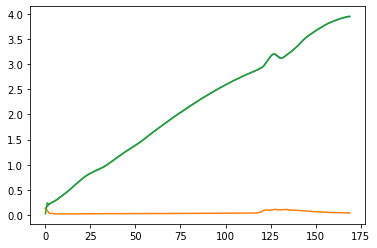

In [6]:
fig, ax = plt.subplots()
ax.plot(errors_salvus)
ax.plot(errors_fem)
ax.plot(errors_fem_salvus)

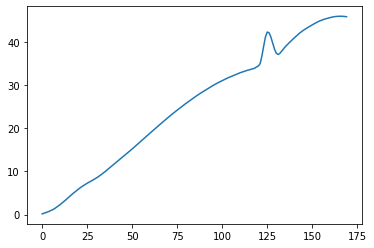

In [7]:
plt.plot(norms)

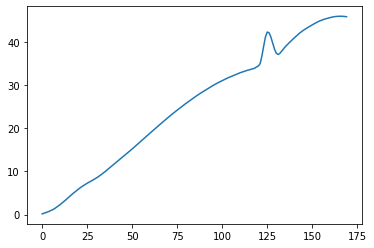

In [8]:
plt.plot(norms)

In [9]:
# Data
data_dir = '../Training_Data/Moseley_Homogeneous_Big/'
data_csv = '../Training_Data/Moseley_Homogeneous_Big_Event0000_Continuous_Predictions.csv'
event = 'Event0000'

training_data = dataset(data_dir,data_csv,event)

initial_timestep = 0
number_of_timestep_to_predict = 1700

In [10]:
model_name = 'NEW_AR_PINN_MSE_E500'
model_type = 'unet'

net = UNet(in_channels=4,out_channels=1)

model = Model(net, device='cuda:0')
model.load(import_path=f'../Training/{model_type}/results/{model_name}.pt',map_location='cuda:0')
model.net = model.net.to(device='cuda:0')

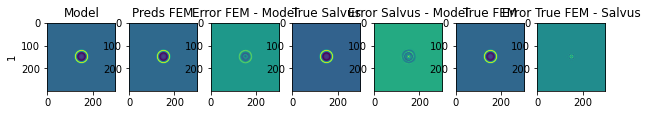

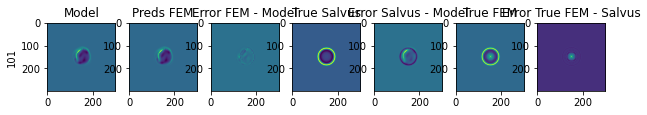

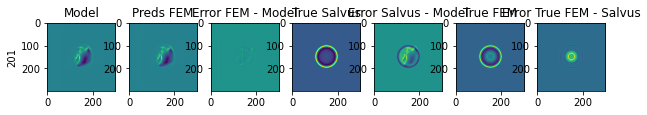

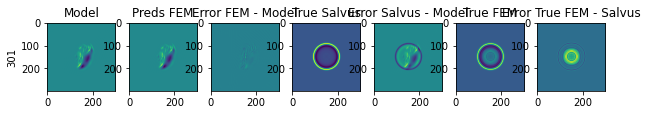

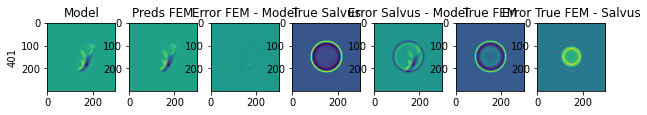

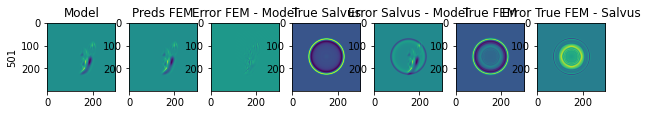

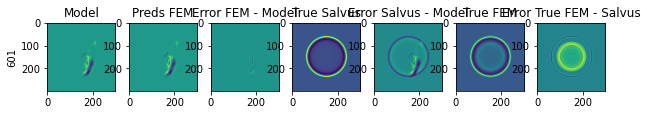

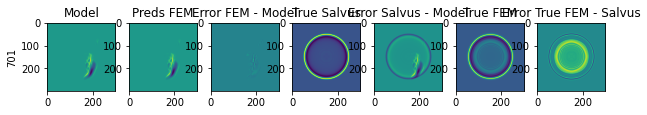

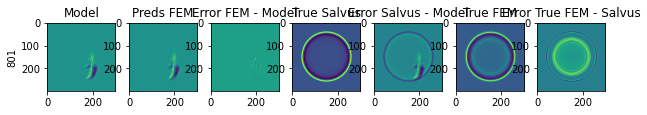

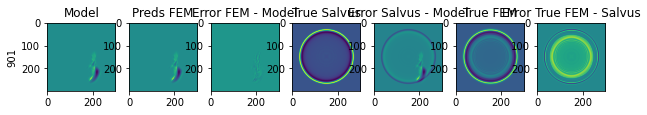

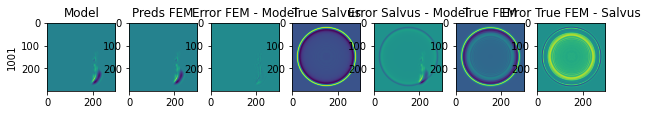

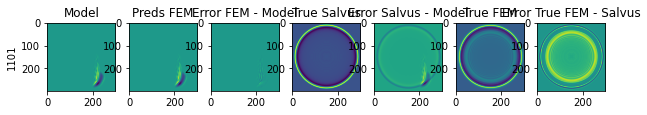

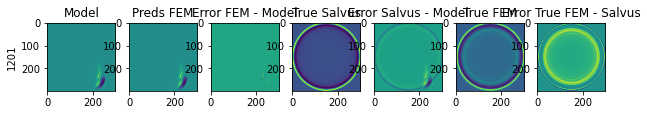

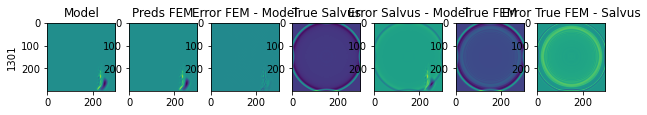

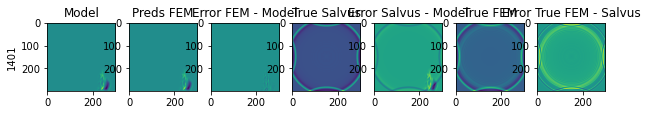

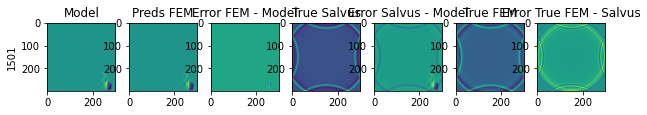

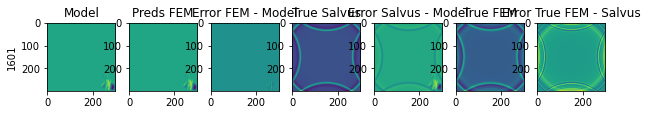

In [11]:
inputs = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]
inputs = inputs.to(device='cuda:0')

inputs_FEM = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]
inputs_FEM = inputs_FEM.to(device='cuda:0')

fem_solver = FEM_Solver(device='cuda:0', dh=5, dt=0.0002, c=2500)

norms = []
errors_salvus = []
errors_fem = []
errors_fem_salvus = []
errors_true_fem_salvus = []

for ts in range(number_of_timestep_to_predict):

    # Pred Model
    pred = model.net(inputs).detach()

    # Pred FEM 
    pred_FEM = fem_solver(inputs).detach()
    true_FEM = fem_solver(inputs_FEM).detach()

    # True Salvus
    true = training_data.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[0]

    # Update inputs
    inputs = torch.cat((inputs,pred),dim=1)[:,1:,:,:]
    inputs_FEM = torch.cat((inputs_FEM,true_FEM),dim=1)[:,1:,:,:]

    norms.append( np.square( pred.cpu().numpy() - true.cpu().numpy() ).mean() ) # MSE

    errors_true_fem_salvus.append( np.mean( np.abs( true_FEM.cpu().numpy() - true.cpu().numpy() ) ) )

    errors_salvus.append( np.mean( np.abs( pred.cpu().numpy() - true.cpu().numpy() ) ) )
    errors_fem.append( np.mean( np.abs( pred.cpu().numpy() - pred_FEM.cpu().numpy() ) ) )
    errors_fem_salvus.append( np.mean( np.abs( true.cpu().numpy() - pred_FEM.cpu().numpy() ) ) )

    if ts % 100 == 1:
        fig, ax = plt.subplots(1,7,figsize=(10,5))
        ax[0].imshow(pred[0,0].cpu().numpy())
        ax[0].set_title('Model')
        ax[0].set_ylabel(ts)

        ax[1].imshow(pred_FEM[0,0].cpu().numpy())
        ax[1].set_title('Preds FEM')

        ax[2].imshow(pred[0,0].cpu().numpy()-pred_FEM[0,0].cpu().numpy())
        ax[2].set_title('Error FEM - Model')

        ax[3].imshow(true)
        ax[3].set_title('True Salvus')

        ax[4].imshow(pred[0,0].cpu().numpy()-true.numpy())
        ax[4].set_title('Error Salvus - Model')

        ax[5].imshow(true_FEM[0,0].cpu().numpy())
        ax[5].set_title('True FEM')

        ax[6].imshow(true_FEM[0,0].cpu().numpy()-true.numpy())
        ax[6].set_title('Error True FEM - Salvus')

        plt.show()

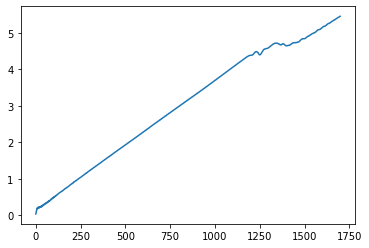

In [13]:
plt.plot(errors_true_fem_salvus)

In [31]:
inputs = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]
inputs = inputs.to(device='cuda:0')

norms = []
norms_FEM_not_recursive = []
norms_FEM_recursive = []

fem_solver = FEM_Solver(device='cuda:0')

for ts in range(number_of_timestep_to_predict):

    epoch_start_time = time.time()

    # Recursive predictions
    pred = model.net(inputs).detach()
    pred_model = pred[0,0].cpu().numpy()

    # Computation next TS with FEM - not recursive
    inputs_fem = training_data.__getitem__(initial_timestep + ts)['wave_input'].transpose(1, 0)[None]
    inputs_fem = inputs_fem.to(device='cuda:0')
    FEM_not_recursive = fem_solver(inputs_fem).detach()
    FEM_not_recursive = FEM_not_recursive[0,0].cpu().numpy()

    # Computation next TS with FEM - recursive
    FEM_recursive = fem_solver(inputs).detach()
    FEM_recursive = FEM_recursive[0,0].cpu().numpy()

    # Get salvus output
    outputs_true = training_data.__getitem__(initial_timestep + ts)['wave_output'].transpose(1, 0)[None]

    # Update inputs
    inputs = torch.cat((inputs,pred),dim=1)[:,1:,:,:]

    # Save norm
    norms.append(np.linalg.norm(outputs_true-pred_model))
    norms_FEM_not_recursive.append(np.linalg.norm(FEM_not_recursive-pred_model))
    norms_FEM_recursive.append(np.linalg.norm(FEM_recursive-pred_model))

    epoch_end_time = time.time()
    total_epoch_time = np.round(epoch_end_time - epoch_start_time, 2)
    print(f'\nTotal time for the timestep {ts} in seconds {total_epoch_time}')


Total time for the timestep 0 in seconds 0.12

Total time for the timestep 1 in seconds 0.12

Total time for the timestep 2 in seconds 0.12

Total time for the timestep 3 in seconds 0.12

Total time for the timestep 4 in seconds 0.12

Total time for the timestep 5 in seconds 0.12

Total time for the timestep 6 in seconds 0.12

Total time for the timestep 7 in seconds 0.13

Total time for the timestep 8 in seconds 0.13

Total time for the timestep 9 in seconds 0.13

Total time for the timestep 10 in seconds 0.13

Total time for the timestep 11 in seconds 0.12

Total time for the timestep 12 in seconds 0.12

Total time for the timestep 13 in seconds 0.12

Total time for the timestep 14 in seconds 0.13

Total time for the timestep 15 in seconds 0.12

Total time for the timestep 16 in seconds 0.13

Total time for the timestep 17 in seconds 0.12

Total time for the timestep 18 in seconds 0.12

Total time for the timestep 19 in seconds 0.12

Total time for the timestep 20 in seconds 0.13

T

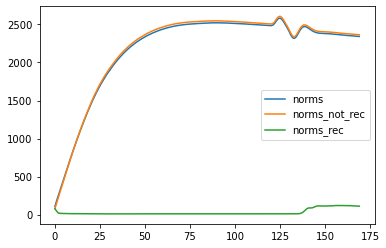

In [32]:
plt.plot(norms,label='norms')
plt.plot(norms_FEM_not_recursive,label='norms_not_rec')
plt.plot(norms_FEM_recursive,label='norms_rec')
plt.legend()